## 나비 이미지 생성 예제



In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
  image_size = 128
  train_batch_size= 16
  eval_batch_size = 16
  num_epochs = 50
  gradient_accumulation_steps = 1
  learning_rate = 1e-4
  lr_warmup_steps = 500
  save_image_epochs = 10
  save_model_epochs = 30
  mixed_precision = "fp16"
  output_dir = "ddpm-butterflies-128"

  push_to_hub = True
  hub_private_repo = False
  overwrite_output_dir = False
  seed = 0

config = TrainingConfig()


In [ ]:
!pip install datasets
from datasets import load_dataset

config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset= load_dataset(config.dataset_name, split="train")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/609 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

In [ ]:
import matplotlib.pyplot as plt

fig,axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
  axs[i].imshow(image)
  axs[i].set_axis_off()
fig.show()

In [ ]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)


In [ ]:
def transform(examples):
  images = [preprocess(image.convert("RGB")) for image in examples["image"]]
  return {"images" : images}
dataset.set_transform(transform)
print(dataset)

In [ ]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [ ]:
!pip install diffusers
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size = config.image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128,128,256,256,512,512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [ ]:
sample_image = dataset[0]["images"].unsqueeze(0)
print(sample_image.shape)

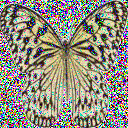

In [ ]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0,2,3,1)+1.0)*127.5).type(torch.uint8).numpy()[0])


In [ ]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [ ]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [ ]:
from diffusers import DDPMPipeline
import math
import os

def make_grid(images, rows, cols):

  w, h = images[0].size
  grid = Image.new("RGB", size=(cols * w, rows * h))
  for i, image in enumerate(images):
    grid.paste(image, box=(i%cols *w, i // cols * h))
  return grid

def evaluate(config, epoch, pipeline):
  images = pipeline(
      batch_size=config.eval_batch_size,
      generator=torch.manual_seed(config.seed),
  ).images

  #Make a grid out of the images
  image_grid = make_grid(images, rows=4, cols=4)
  #save image
  test_dir = os.path.join(config.output_dir, "samples")
  os.makedirs(test_dir, exist_ok=True)
  image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [ ]:
!pip install accelerate
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami
from tqdm.auto import tqdm
from pathlib import Path
import os

def get_full_repo_name(model_id: str, organization: str= None, token:str =None):
  if token is None:
    token = HfFolder.get_token()
  if organization is None:
    username = whoami(token)["name"]
    return f"{username}/{model_id}"
  else:
    return f"{organization}/{model_id}"

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
  accelerator = Accelerator(
      mixed_precision = config.mixed_precision,
      gradient_accumulation_steps=config.gradient_accumulation_steps,
      log_with="tensorboard",
      project_dir=os.path.join(config.output_dir, "logs"),
  )

  if accelerator.is_main_process:
    if config.push_to_hub:
      repo_name = get_full_repo_name(Path(config.output_dir).name)
      repo = Repository(config.output_dir, clone_from=repo_name)
    elif config.output_dir is not None:
      os.makedirs(config.output_dir, exist_ok=True)
    accelerator.init_trackers("train_example")

  model,optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
      model, optimizer, train_dataloader, lr_scheduler)
  global_step = 0

  for epoch in range(config.num_epochs):
    progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in enumerate(train_dataloader):
      clean_images = batch["images"]
      noise = torch.randn(clean_images.shape).to(clean_images.device)
      bs = clean_images.shape[0]

      timesteps = torch.randint(
          0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
      ).long()

      noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
      with accelerator.accumulate(model):
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
        loss = F.mse_loss(noise_pred, noise)
        accelerator.backward(loss)

        accelerator.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

      progress_bar.update(1)
      logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step":global_step}
      progress_bar.set_postfix(**logs)
      accelerator.log(logs, step=global_step)
      global_step+=1
  if accelerator.is_main_process:
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

    if (epoch+1)% config.save_image_epochs == 0 or epoch == config.num_epochs -1:
      evaluate(config, epoch, pipeline)

    if (epoch+1) % config.save_model_epochs == 0 or epoch == config.num_epochs -1:
      if config.push_to_hub:
        repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
      else:
        pipeline.save_pretrained(config.output_dir)

In [ ]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)


In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])